<a href="https://colab.research.google.com/github/Ness731/3-Min-Deeplearning/blob/main/Chapter9._%EA%B2%BD%EC%9F%81%ED%95%98%EB%A9%B0_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN
__GAN__은 Generative Adversarial Network의 약자로, __서로 대립하는 두 모델__이 __경쟁하면서 학습__하는 방법론이다.<br>
- G (Generative) : 새로운 이미지나 음성을 창작한다.
- A (Adversarial) : 가짜 이미지를 생성하는 __생성자(generator)__와 진위 여부를 판별하는 __판별자(discriminator)__가 졍쟁적으로 학습을 진행한다.
- N (Network) : 생성자와 판별자 모두 인공신경망으로 되어있다.

GAN은 비지도 학습 방식을 사용한다. 따라서 많은 양의 데이터를 직접 레이블링할 필요가 없으므로 미래지향적인 방식이라고 평가된다.

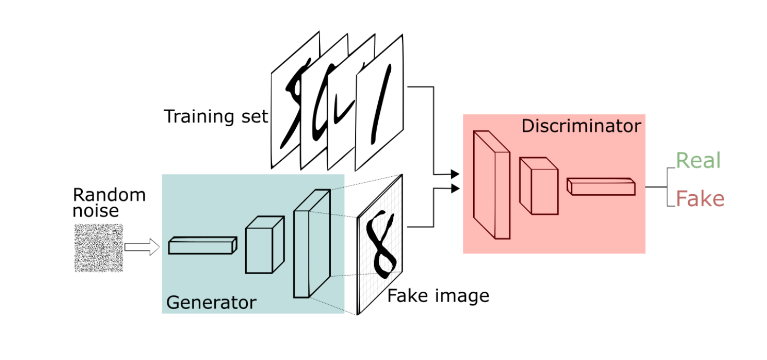

생성자(generator)는 랜덤하게 추출되는 숫자 형태의 텐서를 신경망에 통과시킨 후 이미지 형태로 인코딩하여 가짜 이미지를 생성해낸다. 이후 판별자(discriminator)는 진짜 이미지(training set)과 가짜 이미지(fake image)를 받아 각각의 이미지에 대한 진위 여부를 판단한다.<br>

생성자는 판별자가 가짜 이미지를 정확하게 판별할수록 loss가 커지게 되며, loss를 최소화 하기 위해 더욱 정교한 가짜 이미지를 만들어낸다. 반대로 판별자는 진위 여부를 맞추지 못할 경우 loss가 커지게 되며, loss를 최소화 하기 위해 두 레이블을 정확하게 구분하는 쪽으로 발전한다.<br> 

이처럼 GAN은 __두 신경망의 시스템을 서로 대립하도록 설계__하여 경쟁을 통해 학습하도록 한다.

# CGAN

일반적인 GAN의 코드는 여러 종류의 이미지 중에서 '무엇'을 생성하라는 로직이 없다. 따라서 무작위 벡터를 입력받아 무작위로 이미지를 생성하는 것이다. 즉, __GAN__은 __'원하는' 이미지를 생성하는 능력이 없다.__<br>

이러한 GAN의 한계를 보완하기 위해서 어떤 이미지를 생성할지 알려주는 __레이블__ 값을 입력받아 그에 해당하는 이미지를 생성하는 모델인 조건부 GAN인 __CGAN__이 고안되었다.

## __CGAN 실습__

In [10]:
# 라이브러리 import
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# 하이어파라미터
EPOCHS = 100       # 이터레이션을 총 100회 진행한다.
BATCH_SIZE = 100   # 한 번의 이터레이션에서 100개의 데이터를 다룬다.
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다: ", DEVICE)

다음 장치를 사용합니다:  cuda


In [12]:
# FashionMNIST 데이터셋 로드
trainset = datasets.FashionMNIST('./.data', train=True, 
                                 download=True, 
                                 transform=transforms.Compose([
                                 transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))
                                 ]))
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True)

torch.Size([100, 1, 28, 28])
torch.Size([100])


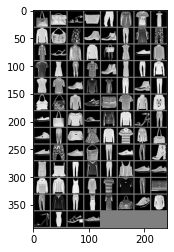

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

이미지의 크기는 28*28이며 흑백이므로 1개의 차원을 가진다. 따라서 이미지를 텐서로 변환시키면 [1, 28, 28]이다.

In [14]:
# CGAN의 생성자(Generator)
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.embed = nn.Embedding(10, 10) # 10개의 차원(dim)을 가진 10개의 레이블 정보

    self.model = nn.Sequential(
        nn.Linear(110, 256),   # z(100) + c(10) = 110 = 레이블을 추가한 무작위 텐서
        nn.LeakyReLU(0.2, inplace=True), # LeakyReLU : 음수값을 표현하기 위해 개선한 ReLU
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(1024, 784), # 28*28 = 784
        nn.Tanh()
    )

  def forward(self, z, labels): # z : 무작위 텐서, 크기는 100
    c = self.embed(labels)      # 1) 10개의 레이블을 임베딩 한다.
    x = torch.cat([z, c], 1)    # 2) z와 c를 1번째 차원에 대해 이어붙인다.
    return self.model(x)        # 3) 생성자 모델에 입력한다.
    # z(100)와 c(10)을 이어붙였으므로 >생성자<의 입력 차원은 110차원.

In [15]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.embed = nn.Embedding(10, 10)

    dropout_p = 0.3

    self.model = nn.Sequential(
        nn.Linear(794, 1024),   # x(784) + c(10) = 794 = 레이블을 추가한 이미지
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(dropout_p),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(dropout_p),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(dropout_p),
        nn.Linear(256, 1), # 최종 출력은 가짜/진짜 여부 (0~1 사이 값)
        nn.Sigmoid()
    )

  def forward(self, x, labels): # x : 입력 이미지, 크기는 28*28
    c = self.embed(labels)      # 1) 10개의 레이블을 임베딩 한다.
    x = torch.cat([x, c], 1)    # 2) x와 c를 1번째 차원에 대해 이어붙인다.
    return self.model(x)        # 3) 판별자 모델에 입력한다.
    # x(784)와 c(10)을 이어붙였으므로 판별자의 입력 차원은 110차원.

In [16]:
# 모델 인스턴스 생성 및 모델의 가중치를 DEVICE로 보내기
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

In [17]:
# 이진 교차 엔트로피 함수
criterion = nn.BCELoss()

# 생성자와 판별자의 최적화 함수(Adam)
g_optimizer = optim.Adam(G.parameters(), lr=0.0003)
d_optimizer = optim.Adam(D.parameters(), lr=0.0003)

In [18]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    if epoch % 10 == 0:
      print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
            .format(epoch,
                    EPOCHS,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item()))
      
      # 1시간 30분 정도 소요됨

이폭 [0/100] d_loss:0.2153 g_loss: 7.4379 D(x):0.94 D(G(z)):0.06
이폭 [10/100] d_loss:0.0000 g_loss: 97.3986 D(x):1.00 D(G(z)):0.00
이폭 [20/100] d_loss:0.0000 g_loss: 96.1708 D(x):1.00 D(G(z)):0.00
이폭 [30/100] d_loss:0.0000 g_loss: 28.9892 D(x):1.00 D(G(z)):0.00
이폭 [40/100] d_loss:0.0000 g_loss: 96.9921 D(x):1.00 D(G(z)):0.00
이폭 [50/100] d_loss:0.0000 g_loss: 98.9384 D(x):1.00 D(G(z)):0.00
이폭 [60/100] d_loss:0.0000 g_loss: 98.5013 D(x):1.00 D(G(z)):0.00
이폭 [70/100] d_loss:0.0000 g_loss: 99.2145 D(x):1.00 D(G(z)):0.00
이폭 [80/100] d_loss:0.0000 g_loss: 99.2002 D(x):1.00 D(G(z)):0.00
이폭 [90/100] d_loss:0.0000 g_loss: 98.1302 D(x):1.00 D(G(z)):0.00


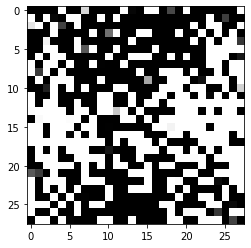

In [19]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()

# __WTF 성능이 왜 이따구야__